# Loading Datasets Notebook

In [2]:
import sys
import os

from PIL.ImageChops import offset

sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import unflatten
from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights
device = "mps"

## Load Files

1) weight_dimensions is a dictionary of the dimensionality for each LoRA in the UNet. Used to save models in Diffusers pipeline format. 

In [3]:
weight_dimensions = torch.load("../files/weight_dimensions.pt")

# Loading a Model from the Dataset of Weights

We load a model from the tensor of flattened LoRas, then call the "unflatten" function which unflattens the weights into LoRA modules and saves them in Diffusers Pipeline format. The same setup works for the dataset of dog-encoding models as well.

In [4]:
import numpy as np


def load_single_model(path, model_num, dt=np.float32, row_size=99648):
    f = open(path, 'rb') #  rb is readbytes
    row_size_bytes = np.dtype(dt).itemsize * row_size
    offset = model_num * row_size_bytes
    # loading one Batch
    f.seek(offset)
    model_data = np.frombuffer(f.read(row_size_bytes), dtype=dt)
    model_tensor = model_data.reshape((1, row_size))
    tensor_batch = torch.from_numpy(model_tensor)
    f.close()
    return tensor_batch.clone().to(device)
        

In [66]:
identity_df = torch.load("../weights_datasets/identities/identity_df.pt")
identity_df

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,identity
file,,,,,,,,,,,,,,,,,,,,,
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,9295
000007.jpg,1,-1,1,1,-1,-1,1,1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,1,9040
000008.jpg,1,1,-1,1,-1,-1,1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,6369
000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,1,-1,-1,1,612
000014.jpg,-1,1,-1,-1,-1,-1,-1,1,1,-1,...,1,-1,-1,-1,-1,1,1,-1,1,7081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202586.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,7037
202594.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,1,-1,1,-1,-1,1,8984
202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,1,...,-1,-1,-1,-1,-1,1,-1,-1,1,9761


In [5]:
single_model = load_single_model("../weights_datasets/identities/all_weights.pt", 8)

In [22]:
EXAMPLE_FACE_DEST = "../example_face"
unflatten(single_model, weight_dimensions, EXAMPLE_FACE_DEST)

In [23]:
def get_pipe(model_path):
    pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
    pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{model_path}/unet", adapter_name="identity1")
    adapters_weights1 = load_peft_weights(f"{model_path}/unet", device=device)
    pipe.unet.load_state_dict(adapters_weights1, strict = False)
    pipe.to(device)
    print("")
    return pipe

def sample_image(pipe, prompt, negative_prompt, guidance_scale=3.0, ddim_steps=50):
    #random seed generator
    generator = torch.Generator(device=device)
    generator = generator.manual_seed(5)
    latents = torch.randn(
            (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
            generator = generator,
            device = device
        ).half()

    #run inference
    image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
    return image
    

Couldn't connect to the Hub: (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 932636f2-ab6b-45f9-a062-2f8390071492)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

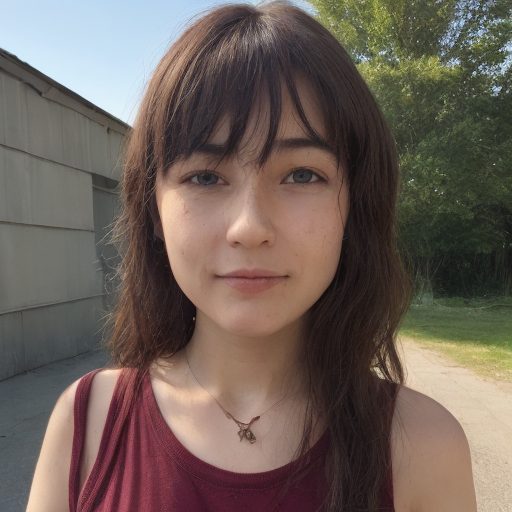

In [24]:
prompt = "sks person"
negative_prompt = "low quality, blurry, unfinished"

pipe = get_pipe(EXAMPLE_FACE_DEST)
sample_image(pipe, prompt, negative_prompt)


In [10]:
EXAMPLE_DEST = "../example_dog"

#### get model with index 8 from dataset of model weights
model = torch.load("../weights_datasets/dogs/dog_weights.pt", map_location=device)[8, :].unsqueeze(0).clone().to(device)

unflatten(model, weight_dimensions, EXAMPLE_DEST)

In [37]:
pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{EXAMPLE_DEST}/unet", adapter_name="identity1")
adapters_weights1 = load_peft_weights(f"{EXAMPLE_DEST}/unet", device=device)
pipe.unet.load_state_dict(adapters_weights1, strict = False)
pipe.to(device)
print("")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

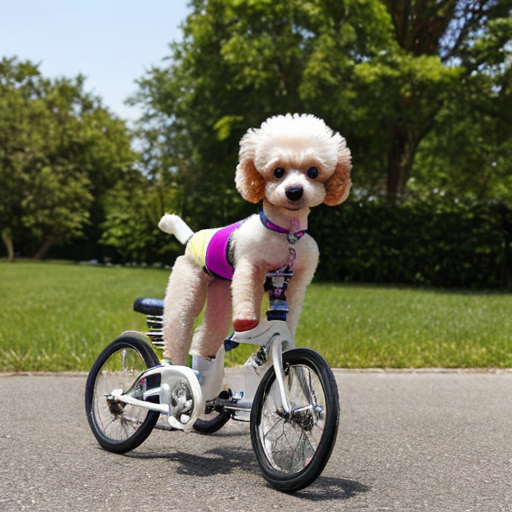

In [38]:
#random seed generator
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "small toy poodle dog on a bicycle"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
#run inference
image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image

Project PCA and unproject

In [6]:
def pca(a):
    mean = torch.mean(a, dim=0)
    std = torch.std(a, dim=0)
    scaled_data = (a - mean)/std
    u,s,v = torch.svd(scaled_data)
    return u,s,v, mean, std

def project(a,v,k, mean, std):
    data = (a-mean)/std
    new = torch.matmul(data,v[:, :k])
    return new

def unproject(projected,v,k, mean, std):
    new = torch.matmul(projected,v[:, :k].T)
    new = new*std+mean
    return new

In [16]:
flat_weights = torch.load("../weights_datasets/dogs/dog_weights.pt", map_location=device).clone().to(device)
u,s,v, mean, std = pca(flat_weights) 

In [17]:
projected_weights = project(flat_weights, v, 10000, mean, std)

In [18]:
unprojected_weights = unproject(projected_weights, v, 10000, mean, std)

In [7]:
V = torch.load("../files/V.pt", map_location=device)
mu = torch.load("../files/mean.pt", map_location=device)
stD = torch.load("../files/std.pt", map_location=device)
proj1000 = torch.load("../files/proj_1000pc.pt", map_location=device)


In [36]:
for e in V:
    print(e.shape)
    break

torch.Size([10000])


In [34]:
projected_single_model = project(single_model, V, 10000, mu, stD)
unprojected_single_model = unproject(projected_single_model, V, 10000, mu, stD)

In [25]:
unprojected_single_model.shape
projected_single_model.shape
proj1000[9, :][:3]

tensor([-39051.7148,  -1859.1208, -12081.1016], device='mps:0')

In [32]:
projected_single_model.shape

torch.Size([1, 10000])

In [91]:
del projected_single_model, unprojected_single_model

In [16]:
unp = unproject(single_model, V, 1000, mu, stD)

In [35]:
unprojected_single_model.shape

torch.Size([1, 99648])

In [40]:
UNPROJECTED_FACE_DEST = "../example_face_unprojected"

unflatten(unprojected_single_model, weight_dimensions, UNPROJECTED_FACE_DEST)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

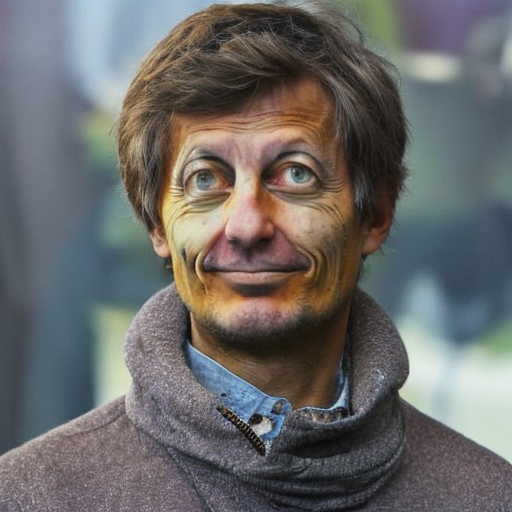

In [41]:
prompt = "sks person"
negative_prompt = "low quality, blurry, unfinished"

pipe = get_pipe(UNPROJECTED_FACE_DEST)
sample_image(pipe, prompt, negative_prompt)

In [22]:
UNPROJECTED_EXAMPLE_DEST = "../example_dog_unprojected"

unprojected_model = unprojected_weights[8, :].unsqueeze(0).clone().to(device)
unflatten(unprojected_model, weight_dimensions, UNPROJECTED_EXAMPLE_DEST)

In [39]:
pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{UNPROJECTED_EXAMPLE_DEST}/unet", adapter_name="identity1_unprojected")
adapters_weights1 = load_peft_weights(f"{UNPROJECTED_EXAMPLE_DEST}/unet", device=device)
pipe.unet.load_state_dict(adapters_weights1, strict = False)
pipe.to(device)
print("")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
labels = torch.load("../weights_datasets/dogs/dog_labels.pt", map_location=device)
labels

['Affenpinscher',
 'Afghan hound',
 'African hunting dog',
 'Airedale',
 'American Staffordshire terrier',
 'Appenzeller',
 'Australian terrier',
 'Basenji',
 'Basset',
 'Beagle',
 'Bedlington terrier',
 'Bernese mountain dog',
 'Black-and-tan coonhound',
 'Blenheim spaniel',
 'Bloodhound',
 'Bluetick',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston bull',
 'Bouvier des Flandres',
 'Boxer',
 'Brabancon griffon',
 'Briard',
 'Brittany spaniel',
 'Bull mastiff',
 'Cairn',
 'Cardigan',
 'Chesapeake Bay retriever',
 'Chihuahua',
 'Chow',
 'Clumber',
 'Cocker spaniel',
 'Collie',
 'Curly-coated retriever',
 'Dandie Dinmont',
 'Dhole',
 'Dingo',
 'Doberman',
 'English foxhound',
 'English setter',
 'English springer',
 'EntleBucher',
 'Eskimo dog',
 'Flat-coated retriever',
 'French bulldog',
 'German shepherd',
 'German short-haired pointer',
 'Giant schnauzer',
 'Golden retriever',
 'Gordon setter',
 'Great Dane',
 'Great Pyrenees',
 'Greater Swiss Mountain dog',
 'Groenendael',


  0%|          | 0/50 [00:00<?, ?it/s]

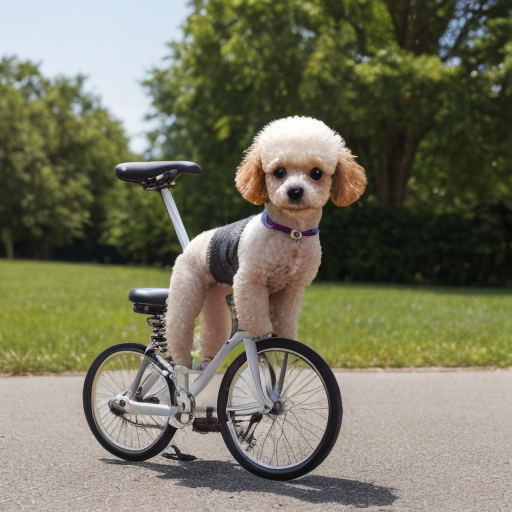

In [40]:
#random seed generator
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "small toy poodle dog on a bicycle"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
#run inference
image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image